In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import networkx as nx
import scipy.io as sio
import matplotlib.colors as mcolors
import pandas as pd
import time
from collections import defaultdict

In [2]:
with open(r'graph_centrality_codes/nodes_edges_weighted.pickle', 'rb') as handle:
    B_matrix_weighted, node_coordinates_weighted = pickle.load(handle)
    
with open(r'graph_centrality_codes/distance.pickle', 'rb') as handle:
    distance_array = pickle.load(handle)  
    
#distance_array (1st col - distance (m), 2nd col - time (s), 3rd col - time in traffic (s))

In [3]:
Origin_Destination_Node_Added = pd.read_pickle('Origin_Destination_Node_Added.pkl')

Connected components: 225
Node count in largest component: 49381


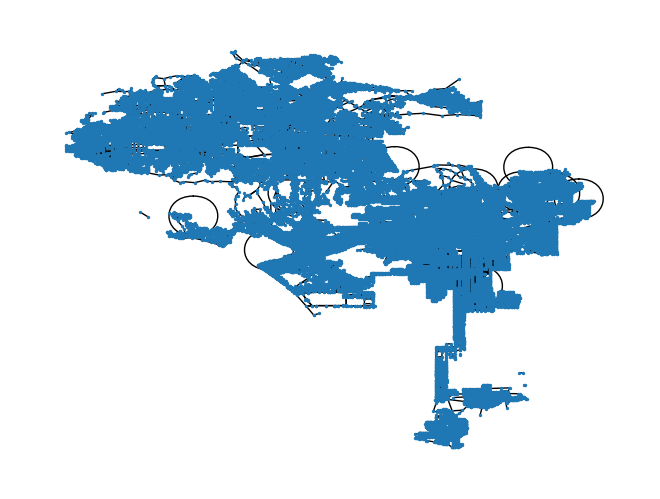

In [4]:
# Display network

Hillside_edgelist = B_matrix_weighted[:,0:2].astype(int)
NetworkEdgeWt_pre = distance_array[:,2]
# NetworkEdgeWt_pre[NetworkEdgeWt_pre == 0] = 1

temp = np.expand_dims(NetworkEdgeWt_pre, axis = 1)

FinalEdge = np.concatenate((Hillside_edgelist, temp), axis = 1).astype(int)
FinalEdge_df = pd.DataFrame(FinalEdge, columns = ['from', 'to', 'weight'])

G = nx.from_pandas_edgelist(FinalEdge_df, source = 'from', target = 'to', edge_attr = True)

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

print('Connected components: ' + str(len(Gcc)))
print('Node count in largest component: ' + str(len(G0.nodes())))
nx.draw(G,pos=node_coordinates_weighted[:,0:2],node_size=2)

In [5]:
# Test to see path output dictionary format

# path_dict_test = nx.single_source_dijkstra_path(G, 31165, cutoff=None, weight='weight')
# path_dict_test

In [6]:
# Check number of unique nodes identified into blocks

unique_nodes = np.unique(Origin_Destination_Node_Added['w_node_id'])
print('Total Nodes: ' + str(len(Origin_Destination_Node_Added['w_node_id'])))
print('Total Unique Nodes: ' + str(len(unique_nodes)))

Total Nodes: 5373682
Total Unique Nodes: 41789


In [7]:
origin_destination_ids_df = Origin_Destination_Node_Added[['w_node_id', 'h_node_id', 'S000_adjusted']]

In [8]:
origin_destination_ids_dict = defaultdict(list)
for origin, destination, S000_adjusted in zip(origin_destination_ids_df['w_node_id'], origin_destination_ids_df['h_node_id'], origin_destination_ids_df['S000_adjusted']):
    origin_destination_ids_dict[origin].append((destination, S000_adjusted))

In [9]:
# Create empty dataframe to store origin ID, destination ID, and path

origin_destination_path_df = pd.DataFrame(columns = ['origin_id', 'destination_id', 'path', 'S000_adjusted'])

In [10]:
no_connection_df = pd.DataFrame(columns = ['origin_id', 'destination_id', 'S000_adjusted'])

In [12]:
start=time.time()

for node_id in unique_nodes[:50]:
# for node_id in unique_nodes:
    try:
        path_dict = nx.single_source_dijkstra_path(G, node_id, cutoff=None, weight='weight')
    except nx.NetworkXNoPath:
        continue

    for destination_with_adj in origin_destination_ids_dict[node_id]:
        if destination_with_adj[0] in path_dict:
            origin_destination_path_df.loc[len(origin_destination_path_df.index)] = [node_id, destination_with_adj[0], path_dict[destination_with_adj[0]], destination_with_adj[1]]
        else:
            no_connection_df.loc[len(no_connection_df.index)] = [node_id, destination, destination_with_adj[1]]

end=time.time()

print('Time taken to find paths: ' + str(end-start))

42.36142897605896


In [44]:
print('Total node pairs parsed: ' + str(len(origin_destination_path_df) + len(no_connection_df)))
print('Total node pairs connected: ' + str(len(origin_destination_path_df)))
print('Total node pairs not connected: ' + str(len(no_connection_df)))

Total node pairs parsed: 1748
Total node pairs connected: 1657
Total node pairs not connected: 91


In [45]:
origin_destination_path_df.to_pickle('origin_destination_path_df.pkl')